## 0- import Section 📚

In [ ]:
print("hi")

In [ ]:
#region imports
import pandas as pd
import numpy as np
import missingno as msno
import random
import re
from nltk import word_tokenize
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from tensorflow.keras import Sequential,layers
# from tensorflow.keras.wrappers.scikit_learn  import  KerasRegressor

rand_state=100

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Ridge
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.impute import SimpleImputer,KNNImputer

from sklearn import set_config

set_config(display="diagram")

from sklearn.model_selection import cross_val_score,KFold,train_test_split
from xgboost import XGBRegressor
import lightgbm as lgbm

from sklearn.ensemble import BaggingRegressor


RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
#endregion

#region settings
random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
#endregion

2022-11-30 09:27:52.246064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 09:27:52.246133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
df_awards=pd.read_csv("../data/220k_awards_by_directors.csv")
df_500_fav=pd.read_csv("../data/500 favorite directors_with wikipedia summary.csv", sep=";",header=0,names=['A', 'B'])
df_900_acc=pd.read_csv("../data/900_acclaimed_directors_awards.csv", sep=";")
df_all_casting=pd.read_csv("../data/AllMoviesCastingRaw.csv", sep=";")
df_all_details = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", sep=";",low_memory=False)
df_lan2country_df = pd.read_csv('../data/language to country.csv')
df_most_common_lang=pd.read_csv("../data/MostCommonLanguageByDirector.csv")
df_spliberg=pd.read_csv("../data/spielberg_awards.csv",encoding='latin1')

## 1- define helper methods 📚

In [ ]:
def show(df_, rows=20, cols=30, title=None):
    if title:
        display(HTML(f'<h2 >{title}</h2 > '))
        with pd.option_context('display.min_rows', rows, 'display.max_columns', cols):
            display(df_)
    return df_

def get_var(df, var_name):
    globals()[var_name] = df
    return df

def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
    return frequency_matrix_count



## 2- Processing 📚

In [ ]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp"])
    
    )
actors_df=(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
director_df=(#2- extracting director_weights
    df_all_casting 
                .melt(id_vars="id",value_vars=["director_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("NaN",np.NaN)
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .drop(columns=["variable","value","year","unit"])
                .merge(df_all_casting[["id","director_name"]],on="id",how="left")
)

data_awards_cleaned=(
    df_awards
            .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
            .groupby(["director_name", "year","outcome"])
            .count()
            .unstack()
            .fillna(0)
            .reset_index()
            .iloc[:,0:4]
            .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
            .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
                won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
                )
            .set_index(["director_name","year"])
)
    

def fame_func(director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

df=(
    df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","spoken_languages_number"] )
).assign(
    fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year),axis=1),
    fame_won= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year,stat=1),axis=1)
    
).drop(columns=["director_name","fiction","year"] )


df_nulls=df.replace(-999,np.NAN)
df

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,12.0,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,10.0,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,5.0,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,5.0,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,7.0,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,-999.0,0,1,1,0.0,8.0,6.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,6.0,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,-999.0,0,0,1,NaN,-999.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,12.0,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


## 3- null analysis 📚

<AxesSubplot:>

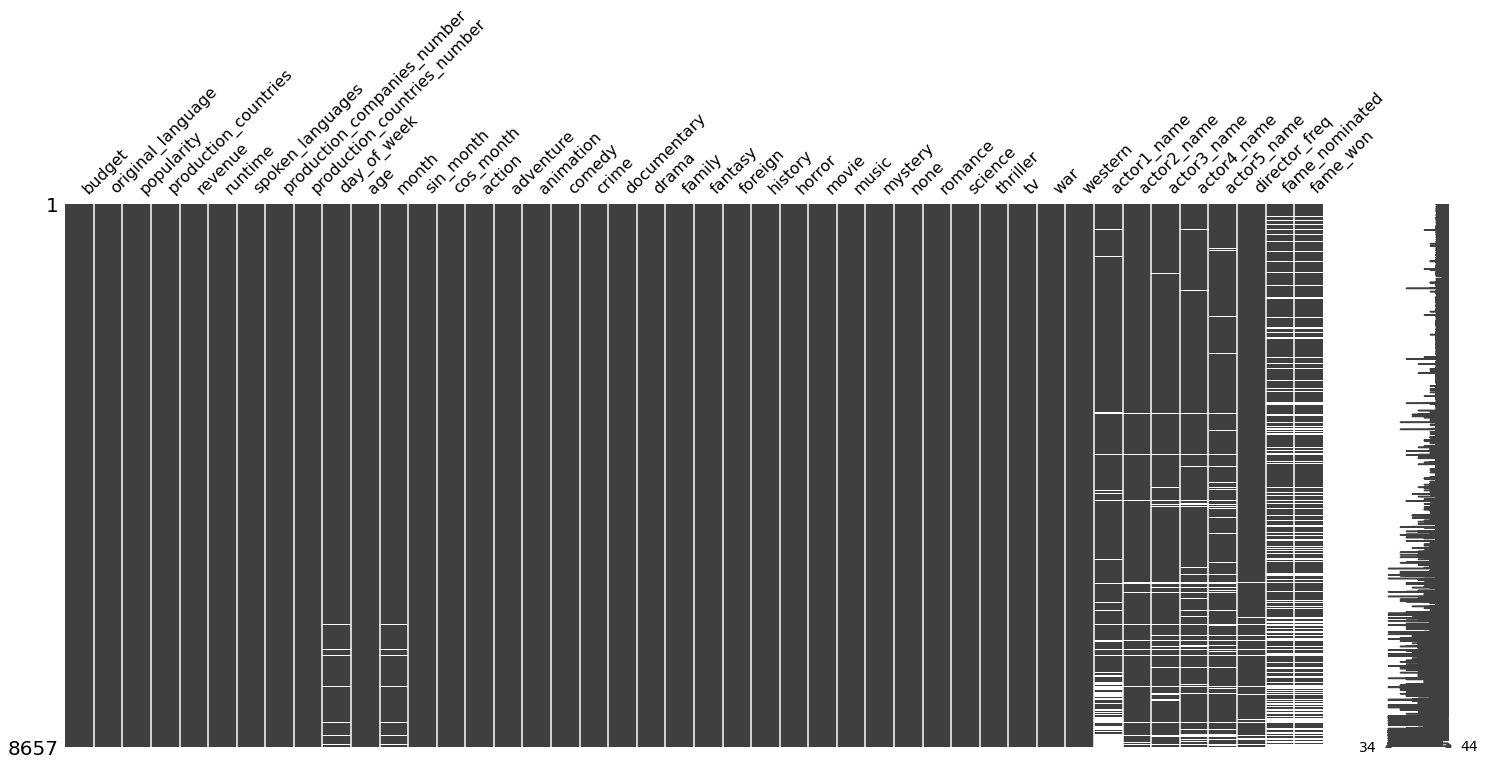

In [ ]:
msno.matrix(df) #some nulls are filled fith -999

<AxesSubplot:>

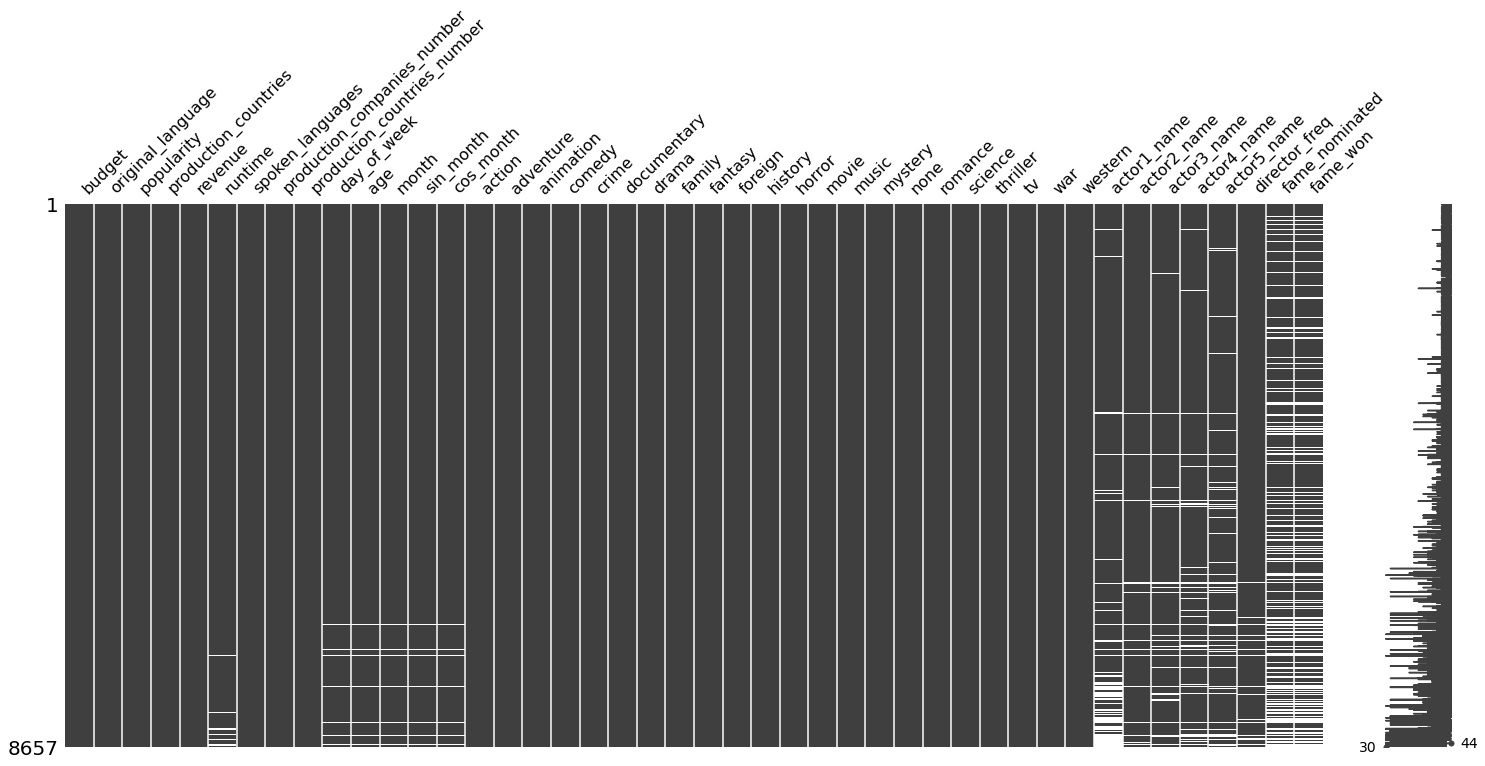

In [ ]:
msno.matrix(df_nulls) #nulls are np.NaN 

## 4- defining X,y  📚

In [ ]:
# X=df_nulls.drop(columns=["revenue","popularity"])
X=df.drop(columns=["revenue","popularity"])
y=df[["revenue","popularity"]]

## 5- defining pipeline 📚

In [ ]:
cat_transformer = Pipeline([
    ("ohc",OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor = ColumnTransformer([
('cat_tr', cat_transformer, ['day_of_week']),
('cat_imputer', SimpleImputer(strategy="most_frequent"), ['day_of_week','actor1_name', 'actor2_name', 
                                                          'actor3_name', 'actor4_name', 'actor5_name', 
                                                          'director_freq', 'fame_nominated', 'fame_won']),
('imputer',SimpleImputer(strategy="median"),["runtime",'age', 'sin_month', 'cos_month'])

]
,remainder="passthrough")
m=Pipeline([
        # ('preprocessor',preprocessor),
        # ('imputer',KNNImputer())
        # ('scaler',StandardScaler()),
        ("estimator",XGBRegressor(
            max_depth=6,           # maximum depth of each tree - try 2 to 10
            learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
            n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
            min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
            colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
            subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
            reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
            reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
            num_parallel_tree=1,   # set > 1 for boosted random forests
        ))
        # ("estimator",lgbm.LGBMRegressor())
        
    ])
m

Pipeline(steps=[('estimator',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=6,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=1, predictor=None,
                              random_state=None, reg_alpha=0.5, reg_lambda=1.0,
                              scale_pos_weight=None, subsample=0.7,
                              tree_method=None, validate_parameters=None,
                              verbosity=None))])

## 6- cross validation and Bagging Regressor 📚

In [ ]:
#cross validation
kf=KFold(n_splits=5,random_state=1,shuffle=True)
cross_val_score(m, X, y.iloc[:,0], cv=kf)

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262

array([0.61084834, 0.65537323, 0.59970346, 0.64681663, 0.57815856])

In [ ]:
np.round(_.mean(),2)

0.62

In [ ]:
#Bagging regressor
reg=BaggingRegressor(base_estimator=m,n_estimators=20,max_features=35,random_state=0,bootstrap_features=True)

In [ ]:

cross_val_score(reg, X, y.iloc[:,0], cv=kf)

array([0.5763336 , 0.62700092, 0.59787596, 0.61204317, 0.58332364])

In [ ]:
np.round(_.mean(),2)

0.6

## 7- Benchmarking models 📚

In [ ]:
models = []
def create_model(learning_rate=0.01, activation='relu', input_size=32):
    opt = layers.Adam(learning_rate=learning_rate)
    # Create your binary classification model
    model = Sequential()
    model.add(layers.Dense(128, input_shape=(input_size,), activation=activation))
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dense(1, activation='linear'))
    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer=opt, loss='rmse', metrics=['rmse'])
    return model


# model_NN = KerasRegressor(build_fn=create_model, epochs=100, input_size=X.shape[1])
models.append(('DummyRegressor', DummyRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor(random_state=rand_state)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(random_state=rand_state)))
models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))
models.append(('XGBRegressor', XGBRegressor(random_state=rand_state)))
models.append(('LGBMRegressor', lgbm.LGBMRegressor(random_state=rand_state)))

# models.append(('Deep NN', model_NN))
results=[]
names=[]
for name, model in models:

    mod = Pipeline([
        ('preprocessor',preprocessor),
        ('imputer',SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    cv_results = cross_val_score(mod, X, y.iloc[:,0], cv=kf)
    
    results.append(cv_results)
    names.append(name)
    

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+19, tolerance: 1.295e+16
  model = cd_fast.enet_coordinate_descent(
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+19, tolerance: 1.273e+16
  model = cd_fast.enet_coordinate_descent(
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

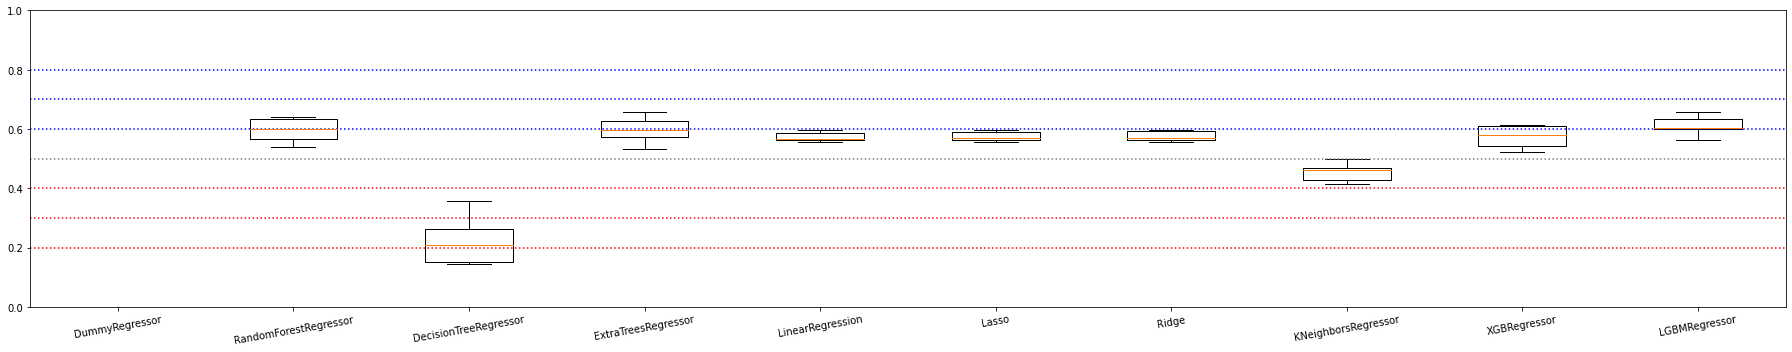

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 5))

ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xticklabels(names, size=10)
plt.xticks(rotation=10)
plt.ylim([0, 1])
plt.axhline(y=0.8, color='b', linestyle=':')
plt.axhline(y=0.7, color='b', linestyle=':')
plt.axhline(y=0.6, color='b', linestyle=':')
plt.axhline(y=0.5, color='gray', linestyle=':')
plt.axhline(y=0.4, color='r', linestyle=':')
plt.axhline(y=0.3, color='r', linestyle=':')
plt.axhline(y=0.2, color='r', linestyle=':')
plt.tight_layout()
plt.show()

## 8- GridSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[500,800,1000,1500,2000],
    'learning_rate':[0.0001,0.001,0.01,0.1],
    'min_child_weight':[2,4,5,8], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7,10],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'reg_alpha':[0.5,1,5,10],
    'reg_lambda':[0.5,1,5,10],
    'num_parallel_tree':[1,5,9]
}

reg = XGBRegressor(nthread=-1)

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=kf, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(X, y.iloc[:,0])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:51:03] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:51:12] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:51:20] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:51:28] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:51:36] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262

[09:55:38] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:55:43] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:55:47] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:55:52] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:55:56] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262

[09:56:29] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:56:32] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:56:35] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:56:37] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:56:39] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/xgboost/data.py:262